## Gamma Ray Burst

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization.hist import hist as fancyhist
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_90536/3206037719.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
# Duration of the time interval during which 90% of the GRB photon counts are observed
T90 = np.array(data[6], dtype = float)
T90_err = np.array(data[names=='T90_error'][0],dtype=float)

ra = np.array(data[3], dtype = float)

decl = np.array(data[4], dtype = float)

fluence = np.array (data[9], dtype = float)
fluence_err = np.array(data[names=='fluence_error'][0],dtype=float)

z =  np.array(data[11], dtype = float)   # we don't know selection effects of long gamma ray burst...

T100 =  np.array(data[12], dtype = float)

In [5]:
print(len(z), len(T90), len(fluence))

8908 8908 8908


In [29]:

# Create a valid mask: only keep positive values ---
mask_T90 = T90 > 0
mask_fluence = fluence > 0
mask = mask_T90 & mask_fluence

T90_masked = T90[mask]
fluence_masked = fluence[mask]


print(len(T90),len(fluence))

7607 7607


Text(0.5, 0, 'log fluence')

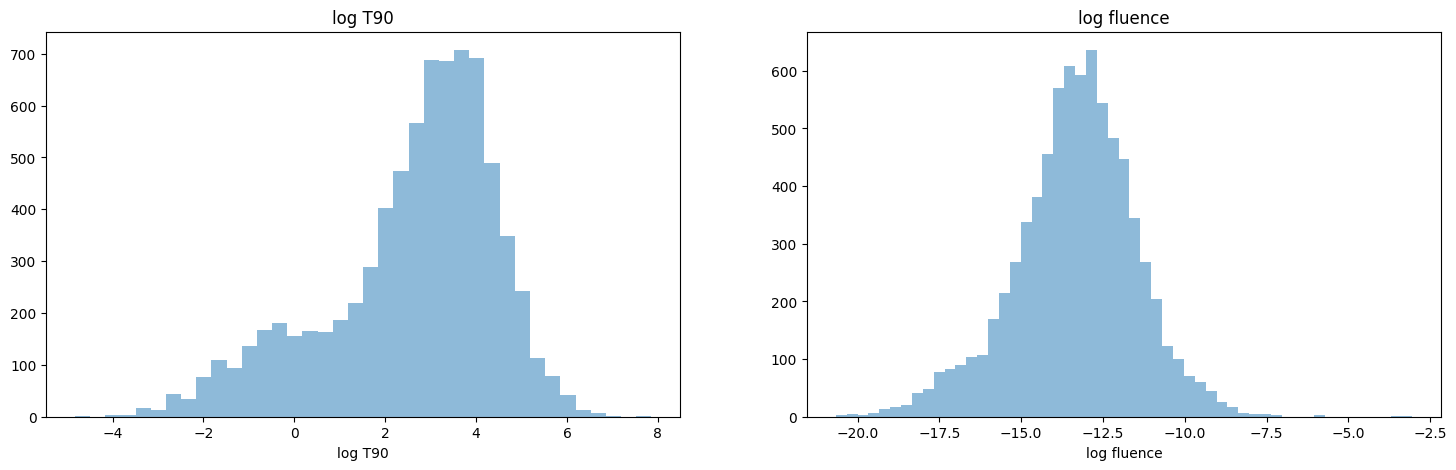

In [30]:
#lets have a look at the data
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Histogram for T90
fancyhist(np.log(T90), bins='scott', ax=axs[0], alpha=0.5)
axs[0].set_title('log T90')
axs[0].set_xlabel('log T90')

#Histogram for fluence
fancyhist(np.log(fluence), bins='scott', ax=axs[1], alpha=0.5)
axs[1].set_title('log fluence')
axs[1].set_xlabel('log fluence')

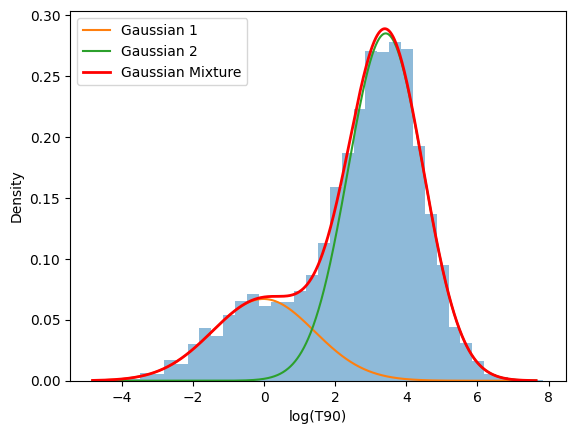

In [31]:

# Apply log transform safely (no zeros or negatives left) ---
log_T90 = np.log(T90_masked).reshape(-1, 1)

# Fit a 2-component Gaussian Mixture to log(T90) ---
gm = GaussianMixture(n_components=2, random_state=0)
gm.fit(log_T90)

# Prepare a smooth x-axis for plotting the mixture ---
x = np.linspace(log_T90.min(), log_T90.max(), 1000).reshape(-1, 1)

#Compute individual Gaussian components ---
gaussian_1 = norm.pdf(x, gm.means_[0, 0], np.sqrt(gm.covariances_[0, 0, 0]))
gaussian_2 = norm.pdf(x, gm.means_[1, 0], np.sqrt(gm.covariances_[1, 0, 0]))

# Plot histogram and mixture fit ---
fancyhist(log_T90, bins='scott', alpha=0.5, density=True)
plt.xlabel('log(T90)')
plt.ylabel('Density')

# Weighted Gaussians
plt.plot(x, gaussian_1 * gm.weights_[0], label='Gaussian 1')
plt.plot(x, gaussian_2 * gm.weights_[1], label='Gaussian 2')

# Full mixture (using model's log-likelihood)
plt.plot(x, np.exp(gm.score_samples(x)), label='Gaussian Mixture', color='red', linewidth=2)
plt.legend()
plt.show()

In [38]:
### Probability of GRBs being in the first and second Gaussian

probabilities = gm.predict_proba(log_T90) #the posterior probability that the sample belongs to each Gaussian component in the mixture.
#print(probabilities)
more_probable_gaussian = np.argmax(probabilities, axis=1)

print("number of GRBs more probable in gaussian 1:", np.sum(more_probable_gaussian == 0))
print("number of GRBs in gaussian 2:", np.sum(more_probable_gaussian == 1))
print('----------------------')
print("It's more probable to observe long Gamma Ray Bursts")


number of GRBs more probable in gaussian 1: 1656
number of GRBs in gaussian 2: 5951
----------------------
It's more probable to observe long Gamma Ray Bursts


In [74]:
#let's find the intersection between the gaussians
x_intersec = np.linspace(0, 4, 100).reshape(-1,1) 
gaussian_1_intersec = norm.pdf(x_intersec, gm.means_[0], np.sqrt(gm.covariances_[0]))
gaussian_2_intersec = norm.pdf(x_intersec, gm.means_[1], np.sqrt(gm.covariances_[1]))

intersection = np.exp(x_intersec[np.argmin(np.abs(gaussian_1_intersec * gm.weights_[0] - 
                                         gaussian_2_intersec * gm.weights_[1]))])
print("log threshold between the two gaussians: ", np.log(intersection[0]))
print("Threshold between the two gaussians: ", intersection[0]) 

#while means are:
mean_1 = np.exp(gm.means_[0])
mean_2 = np.exp(gm.means_[1])


log threshold between the two gaussians:  1.3333333333333335
Threshold between the two gaussians:  3.7936678946831783


## KDE

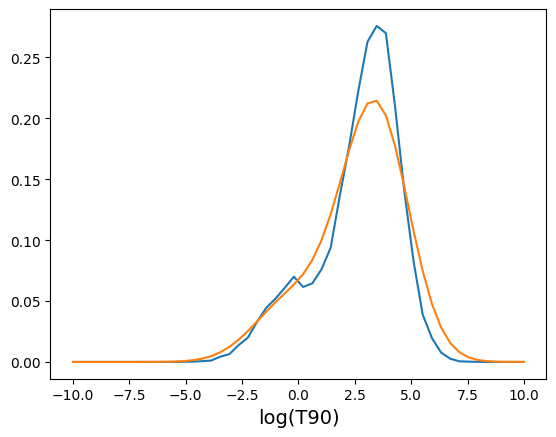

In [40]:
#KDE in order to take a look
from sklearn.neighbors import KernelDensity

def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)
    
#different band width
xgrid =np.linspace(-10,10)
plt.xlabel('log(T90)', fontsize=14)
pdf = kde_sklearn(np.log(T90),bandwidth=0.2)
plt.plot(xgrid,pdf)
pdf = kde_sklearn(np.log(T90),bandwidth=1)
plt.plot(xgrid,pdf)

In [41]:
#FIND THE OPTIMAL BANDWIDTH WITH K-FOLD VALIDATION

#determine the bandwidth for T90
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.01,1.0, 15) # Test 15 bandwidths from 0.1 to 1.0
#print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(np.log(T90)[:, None]) #Fit the histogram data that we started the lecture with.
h_opt_T90 = grid.best_params_['bandwidth']
print(h_opt_T90)


0.29285714285714287


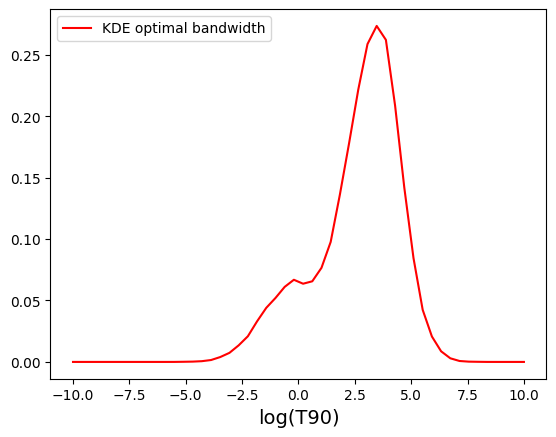

In [42]:
pdf = kde_sklearn(np.log(T90),bandwidth=h_opt_T90)
plt.xlabel('log(T90)', fontsize=14)
plt.plot(xgrid, pdf, label='KDE optimal bandwidth', c='red')
plt.legend()
plt.show()

In [43]:
#FIND THE OPTIMAL BANDWIDTH of fluence

bwrange = np.linspace(0.01,1.0, 15) # Test 15 bandwidths from 0.1 to 1.0
#print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(np.log(fluence)[:, None]) #Fit the histogram data that we started the lecture with.
h_opt_fluence = grid.best_params_['bandwidth']
print(h_opt_fluence)

0.7171428571428572


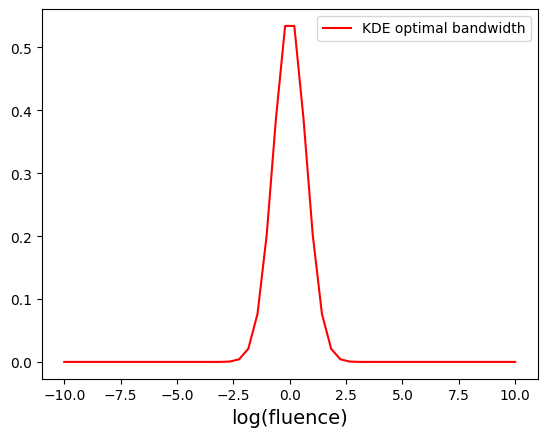

In [44]:
pdf = kde_sklearn(fluence,bandwidth=h_opt_fluence)
plt.xlabel('log(fluence)', fontsize=14)
plt.plot(xgrid, pdf, label='KDE optimal bandwidth', c='red')
plt.legend()
plt.show()


## find the two clusters

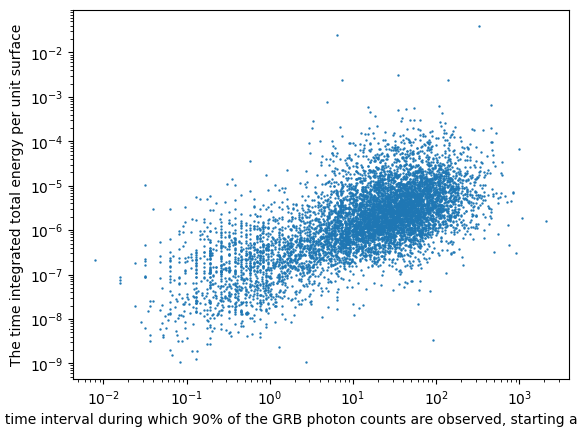

In [45]:
#looking at the data
plt.scatter(T90,fluence,s=0.5)
plt.xlabel('Duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%')
plt.ylabel('The time integrated total energy per unit surface')
plt.xscale('log')
plt.yscale('log')
plt.show()

I want to find the 2 cluster that i expect to have within the data: I shoud find a class of GRB that are more luminous but have a shorter duration, and less luminous ones that have higher dutarion

## KMeans

(7607, 2)
CLUSTER CENTERS: [[  0.16930721 -15.45843923]
 [  3.50835221 -12.55145348]]


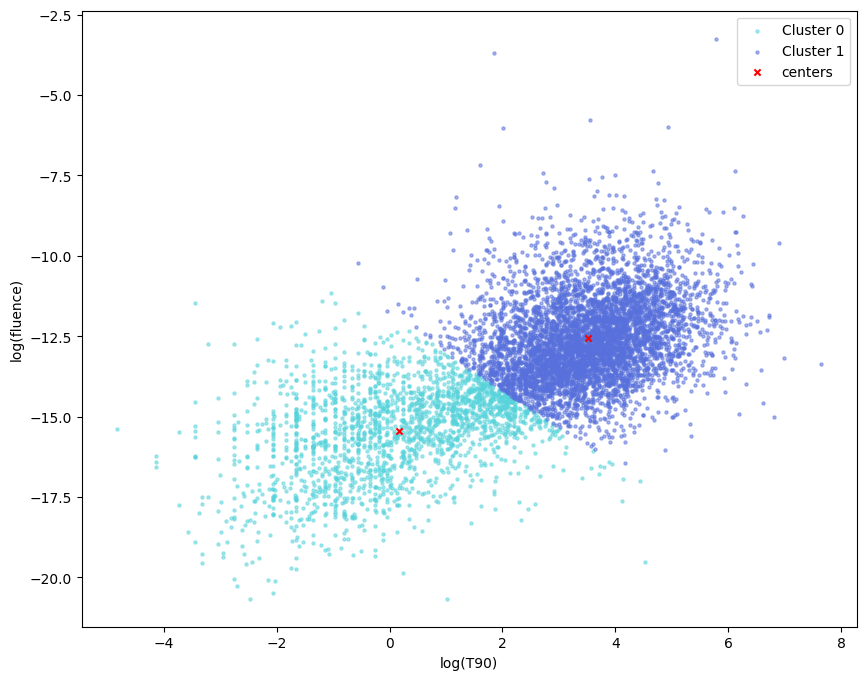

In [46]:
from sklearn.cluster import KMeans


X = np.array([np.log(T90), np.log(fluence)]).T
print(X.shape)
clf = KMeans(n_clusters=2)
clf.fit(X)
centers = clf.cluster_centers_
labels = clf.predict(X)
plt.figure(figsize = (10,8))

colors = sns.color_palette("hls", 8)[4:]
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1],
                color=colors[ii],alpha=0.5, s= 5, label = 'Cluster %i'%ii)

plt.scatter(centers[:,0], centers[:,1], color='red', marker='x', s=20, label='centers')

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('log(T90)')
plt.ylabel('log(fluence)')
plt.legend()

print("CLUSTER CENTERS:", centers)

## now we try with mean-shift

In [47]:
# Combine both features
X = np.column_stack((np.log(T90), np.log(fluence)))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Estimate bandwidth using scaled data
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2) #choose the distance that is larger than 20% of all pairwise distances

# Fit Mean Shift with consistent scaling
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(X_scaled)

print('Bandwidth (in scaled units):', bandwidth)

Bandwidth (in scaled units): 0.9081174331755713


[-1  0  1  2  3]
0.9081174331755713
number of estimated clusters : 4


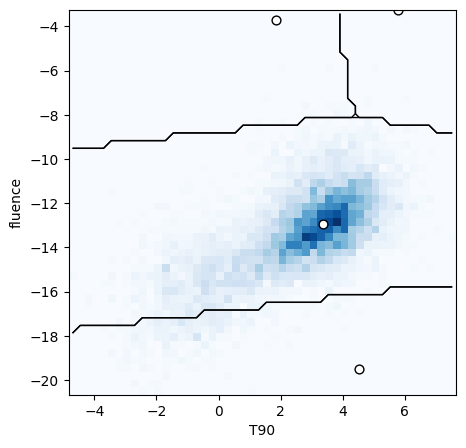

In [48]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('fluence')

plt.show()



Mean Shift and K-Means are both unsupervised clustering algorithms, but they differ significantly in how they handle outliers.

K-Means minimizes the sum of squared distances between data points and their assigned cluster centroids:

$$J = \sum_{i=1}^{k} \sum_{x_j \in C_i} \| x_j - \mu_i \|^2
    $$


 Mean Shift, on the other hand, is a mode-seeking algorithm based on kernel density estimation. It iteratively moves data points toward regions of higher data density according to a kernel function (typically Gaussian) and a bandwidth parameter $h$:

 $$
    m(x) = \frac{\sum_i K\!\left(\frac{x - x_i}{h}\right) x_i}{\sum_i K\!\left(\frac{x - x_i}{h}\right)}
    $$

Since the kernel function $K(\cdot)$ assigns lower weights to distant points, outliers have very little influence on the location of density peaks. Consequently, Mean Shift is less sensitive to outliers than K-Means.

 
K-Means is more affected by outliers because its centroid updates are based on squared distances, whereas Mean Shift’s kernel weighting naturally reduces the influence of distant (outlier) points.

Bandwidth estimated: 0.505
[-1  0  1  2  3  4  5  6  7  8  9]
0.505
number of estimated clusters : 10


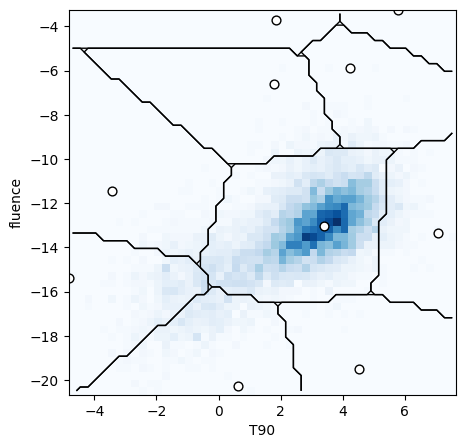

In [49]:
#using optimal banwidth from KDE

scaler = preprocessing.StandardScaler()
bandwidth = (h_opt_T90 + h_opt_fluence)/2 #I'm making the mean of the optimal bandwidth of the 2 varibles (not good without normalization)
ms = MeanShift(bandwidth=bandwidth,
               bin_seeding=True,
               cluster_all=False)
ms = ms.fit(scaler.fit_transform(X))
print('Bandwidth estimated:', bandwidth)


labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('fluence')

plt.show()

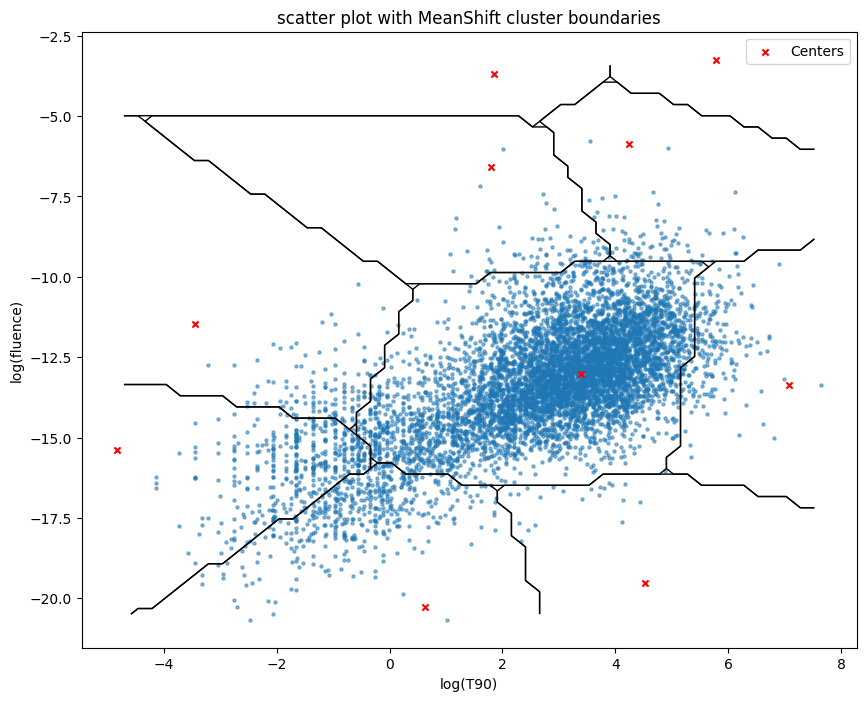

In [50]:
plt.figure(figsize=(10, 8))
labels = ms.predict(X)

# plot the data color-coded by cluster id
colors = sns.color_palette("Paired")

plt.scatter(X[:, 0], X[:, 1], alpha=0.5, s=5)

# plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=20, label='Centers')

# plot the cluster boundaries
for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    plt.contour(x_centers, y_centers, Hcp, [-0.5, 0.5], linewidths=1, colors='k')

plt.xlabel('log(T90)')
plt.ylabel('log(fluence)')
plt.legend()
plt.title('scatter plot with MeanShift cluster boundaries')
plt.show()

In [60]:
import pandas as pd
#features I am interested in 
par_keys = ['ra', 'decl', 'pos_error', 'T90', 'T90_error','fluence', 'fluence_error', 'redshift', "'T100'"]

df = pd.DataFrame(data.T, columns=names)
df_subset = df[par_keys].copy()

for col in par_keys:
    df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')

#select only data with a physical meaning
df_pos = df_subset[(df_subset['T90'] > 0) & (df_subset["'T100'"] > 0) & (df_subset['redshift'] > 0) & (df_subset['fluence'] > 0)]


## T90 vs Redshift

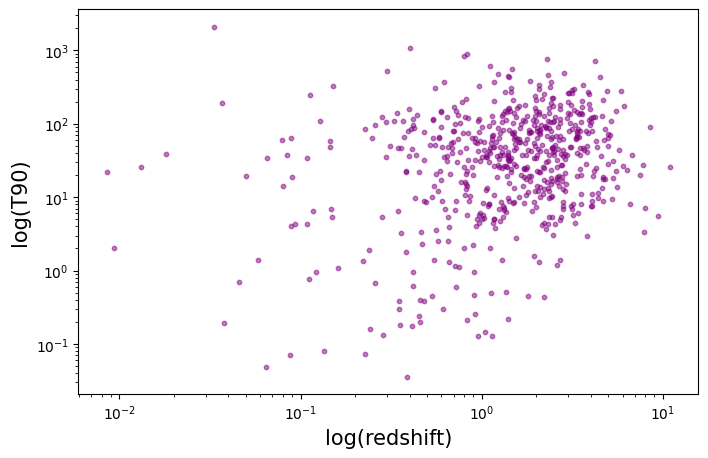

In [61]:

T90_new = np.array(df_subset['T90'][(df_subset['T90'] > 0) & (df_subset['redshift'] > 0)])
redshift_new = np.array(df_subset['redshift'][(df_subset['T90'] > 0) & (df_subset['redshift'] > 0)])

fig = plt.figure(figsize=(8, 5))
plt.scatter(redshift_new, T90_new, alpha=0.5, s=10, color='purple')

plt.xlabel('log(redshift)',fontsize=15)
plt.ylabel('log(T90)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.show()


## K means with 2 clusters

In [62]:
rt = np.column_stack((np.log(redshift_new), np.log(T90_new)))
print(rt.shape)


(611, 2)


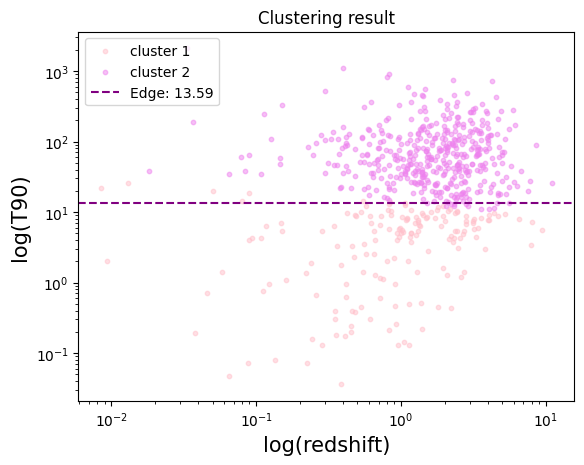

In [63]:
clf = KMeans(n_clusters=2,n_init='auto')
clf.fit(rt)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(rt)

colors = ['pink', 'violet']

for i in range(2):
    plt.scatter(redshift_new[labels==i], T90_new[labels==i], 
                color=colors[i],alpha=0.5, s=10, label=f'cluster {i+1}')

edge = np.exp(np.mean(centers[:, 1]))

plt.axhline(y=edge, color='purple', linestyle='--', label=f'Edge: {edge:.2f}')

plt.xlabel('log(redshift)',fontsize=15)
plt.ylabel('log(T90)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.title('Clustering result')
plt.legend(loc='upper left')
plt.show()


Adding the redshift as a feature, it seems that the algorithm still finds a division only (or almost only) in T90 and bring the limit between the two types of GRB from 5 to 14

In [64]:
count_ones = np.count_nonzero(labels == 1)
print(f'Numb of obj in first cluster: {count_ones}\nNumber of obj in the second cluster {len(labels)-count_ones}')


Numb of obj in first cluster: 443
Number of obj in the second cluster 168


## PCA

In [65]:
plot_keys = [key for key in par_keys if '_error' not in key] #You exclude all columns with _error in the name 
plot_data = df_pos[plot_keys].dropna(how='any').to_numpy() #avoid to take rows with NaN data
#That’s 7 columns, but if one ('T100') has been filtered out or renamed, you might end up with 6.
scaler = StandardScaler()
data_scaled = scaler.fit_transform(plot_data)

np.random.seed(8)
n_components = len(plot_data[1,:])

pca = PCA(n_components=n_components)
pca.fit(data_scaled) 
data_transformed = pca.transform(data_scaled)  

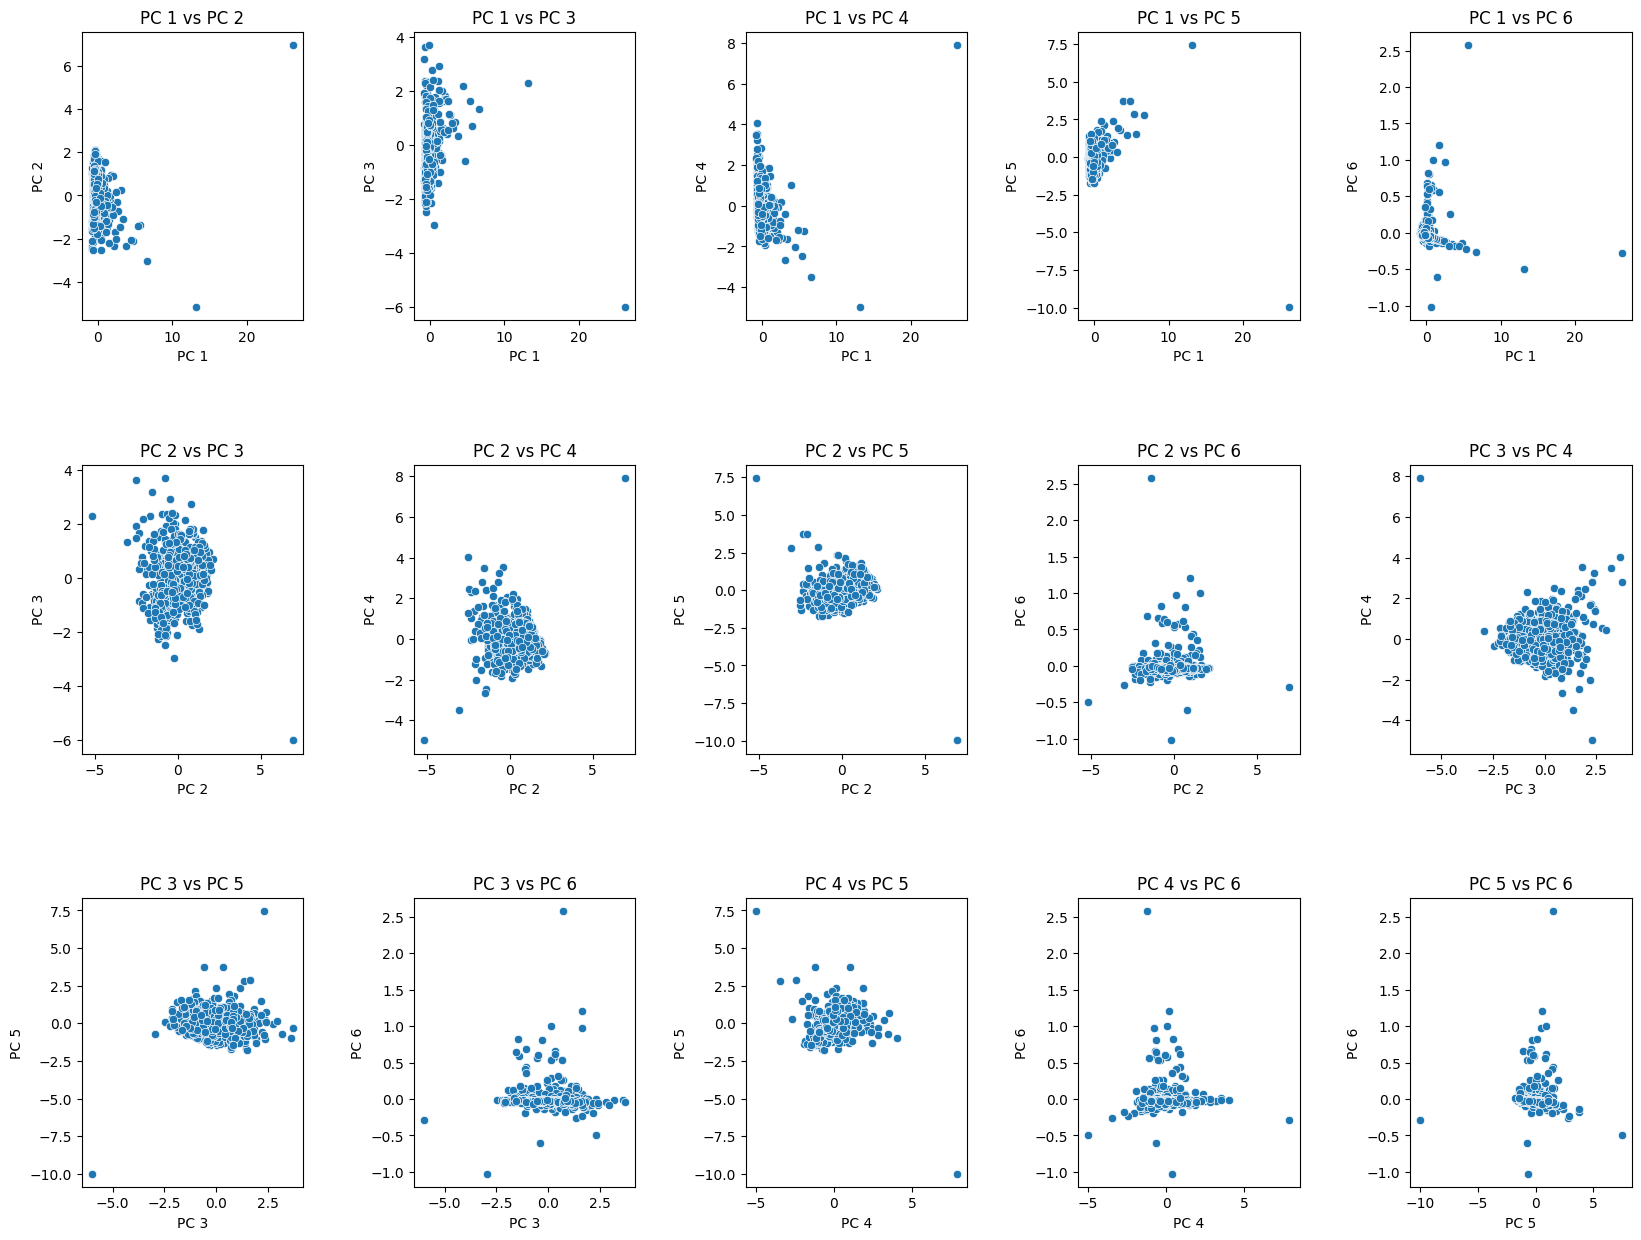

In [66]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

titles = [
    ('PC 1 vs PC 2', 0, 1), ('PC 1 vs PC 3', 0, 2), ('PC 1 vs PC 4', 0, 3), ('PC 1 vs PC 5', 0, 4), ('PC 1 vs PC 6', 0, 5),
    ('PC 2 vs PC 3', 1, 2), ('PC 2 vs PC 4', 1, 3), ('PC 2 vs PC 5', 1, 4), ('PC 2 vs PC 6', 1, 5),
    ('PC 3 vs PC 4', 2, 3), ('PC 3 vs PC 5', 2, 4), ('PC 3 vs PC 6', 2, 5),
    ('PC 4 vs PC 5', 3, 4), ('PC 4 vs PC 6', 3, 5),
    ('PC 5 vs PC 6', 4, 5)
]

for ax, (title, i, j) in zip(axs.flatten(), titles):
    sns.scatterplot(x=data_transformed[:, i], y=data_transformed[:, j], ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel(f'PC {i+1}')
    ax.set_ylabel(f'PC {j+1}')

plt.show()

In [67]:
evals = pca.explained_variance_ratio_
for idx, r in enumerate(evals):
    print(f'Comp {idx+1} - variance explained : {100*r:.2f} - cumulative : {evals.cumsum()[idx]*100}')


Comp 1 - variance explained : 34.20 - cumulative : 34.202219465048174
Comp 2 - variance explained : 17.85 - cumulative : 52.04778244058479
Comp 3 - variance explained : 17.62 - cumulative : 69.66782495553467
Comp 4 - variance explained : 15.69 - cumulative : 85.3618604976954
Comp 5 - variance explained : 14.11 - cumulative : 99.47178637707275
Comp 6 - variance explained : 0.53 - cumulative : 100.00000000000003


2.1253796279252315
Number of clusters found by mean shift : 6


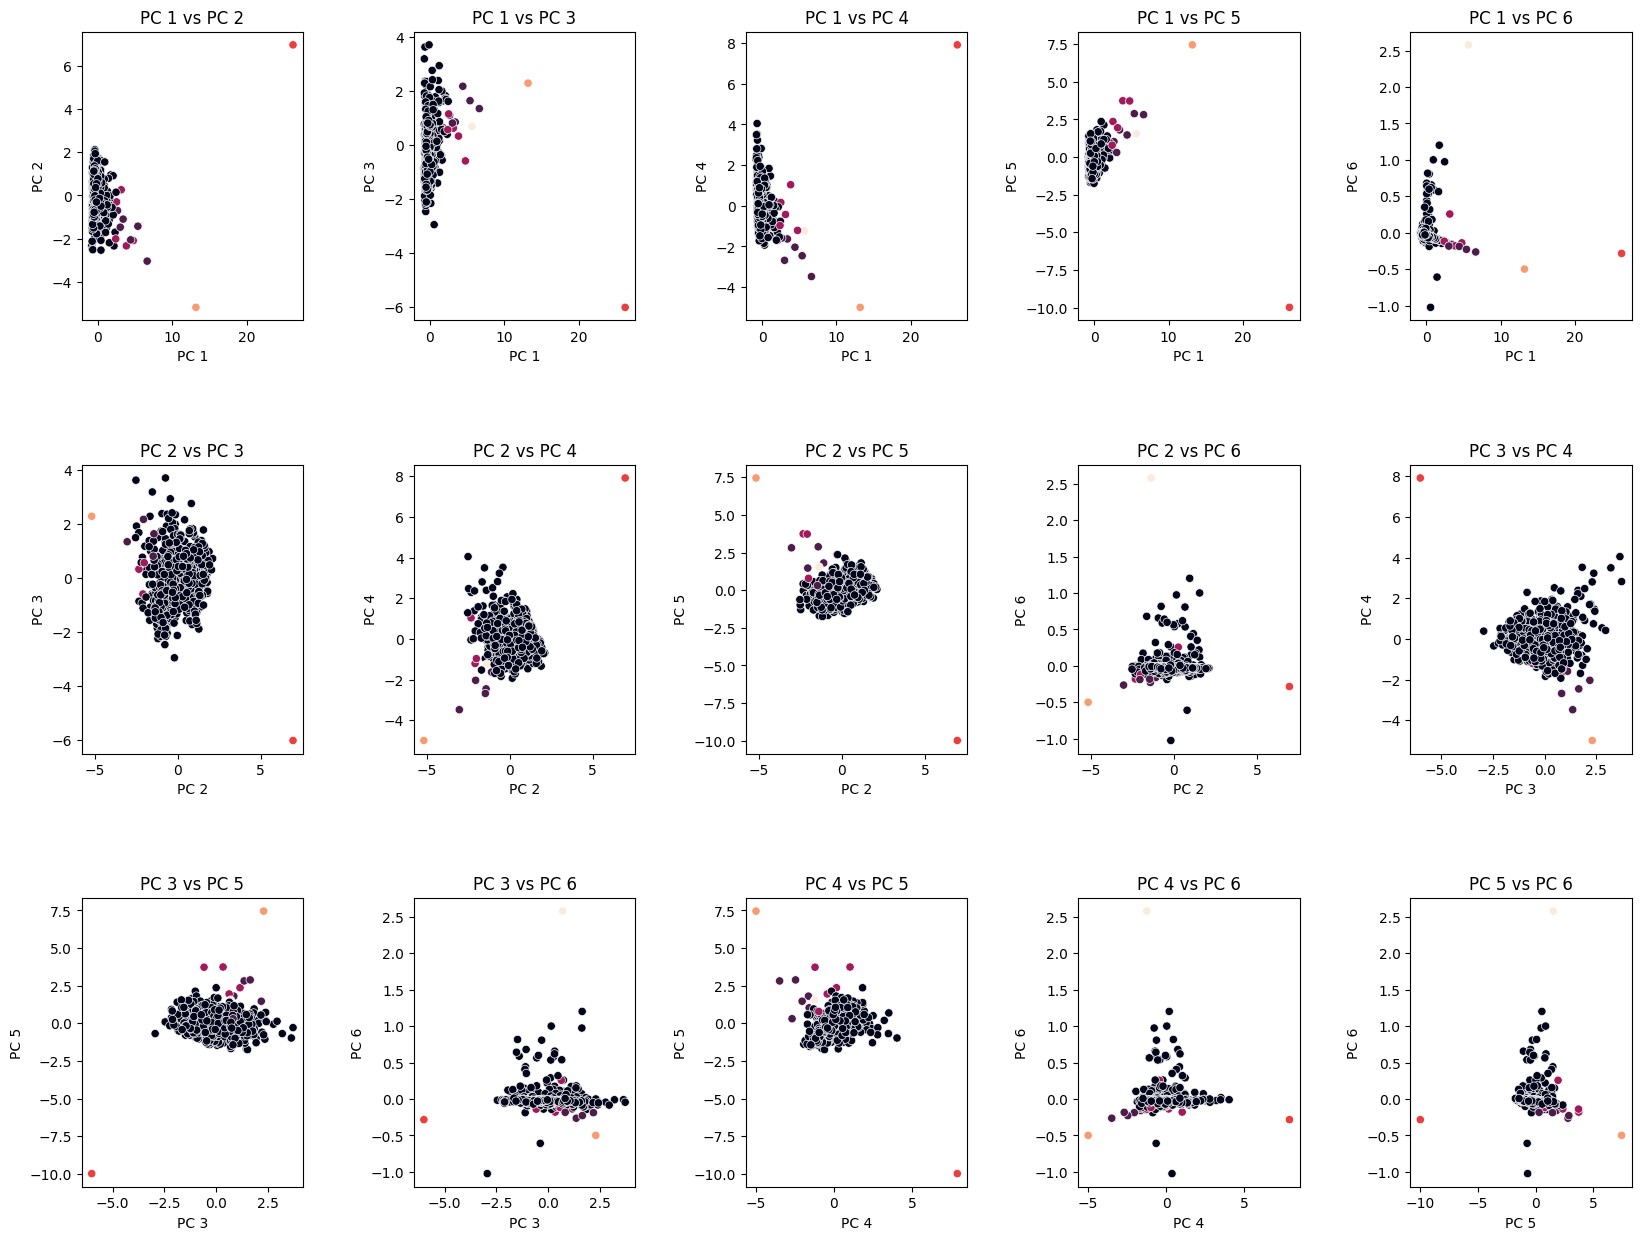

In [79]:
#vedere la separazione dei cluster in tutte le combinazioni dei PC, e capire se il clustering è significativo.
import seaborn as sns

b = estimate_bandwidth(data_transformed) 
print(b)

ms = MeanShift(bandwidth=b, 
               bin_seeding=True, 
               cluster_all=True)
clusters = ms.fit_predict(data_transformed)

labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters = len(labels_unique[labels_unique >= 0])

print(f'Number of clusters found by mean shift : {n_clusters}')

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)


titles = [
    ('PC 1 vs PC 2', 0, 1), ('PC 1 vs PC 3', 0, 2), ('PC 1 vs PC 4', 0, 3), ('PC 1 vs PC 5', 0, 4), ('PC 1 vs PC 6', 0, 5),
    ('PC 2 vs PC 3', 1, 2), ('PC 2 vs PC 4', 1, 3), ('PC 2 vs PC 5', 1, 4), ('PC 2 vs PC 6', 1, 5),
    ('PC 3 vs PC 4', 2, 3), ('PC 3 vs PC 5', 2, 4), ('PC 3 vs PC 6', 2, 5),
    ('PC 4 vs PC 5', 3, 4), ('PC 4 vs PC 6', 3, 5),
    ('PC 5 vs PC 6', 4, 5)
]

for ax, (title, i, j) in zip(axs.flatten(), titles):
    sns.scatterplot(x=data_transformed[:, i], y=data_transformed[:, j], hue=clusters, palette='rocket', ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel(f'PC {i+1}')
    ax.set_ylabel(f'PC {j+1}')

plt.show()


MeanShift predict a lot of clusters and looking at the plots in seems that the "clusters" are in reality single points that are outside the big cloud in the centers.\
It is sensible to outlyers!

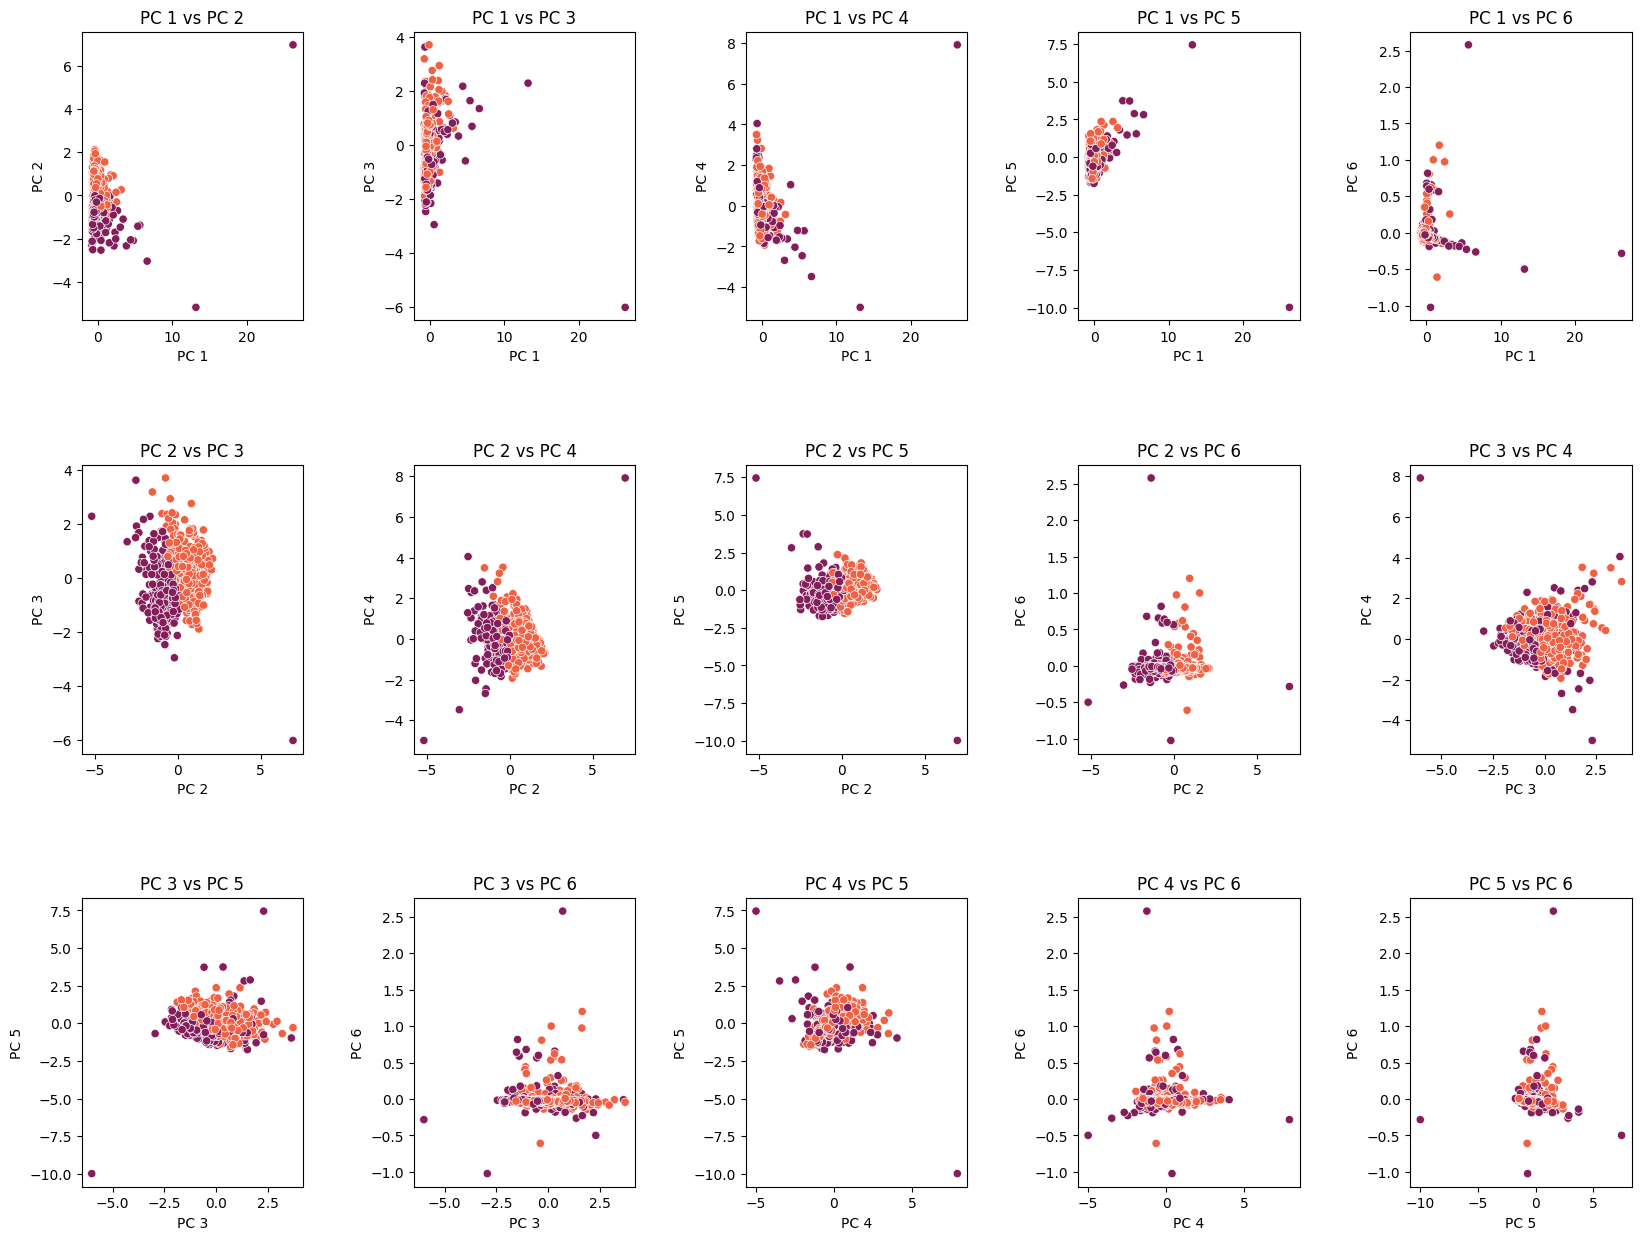

In [77]:
clf = KMeans(n_clusters=2, n_init='auto')
clf.fit(data_scaled)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(data_scaled)

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for ax, (title, i, j) in zip(axs.flatten(), titles):
    sns.scatterplot(x=data_transformed[:, i], y=data_transformed[:, j], hue=labels, palette='rocket', ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel(f'PC {i+1}')
    ax.set_ylabel(f'PC {j+1}')

plt.show()


K means seems to find two clusters very well distincted

In [78]:
count_ones = np.count_nonzero(labels == 1)
print(f'Numb of obj in first cluster: {count_ones}\nNumber of obj in the second cluster {len(labels)-count_ones}')


Numb of obj in first cluster: 358
Number of obj in the second cluster 251



The cluster founded here, using all the features seems to be much more balanced than the one founded before